# Double-Bracket Iteration Strategy: Local Z search

In this example, we demonstrate the usage of the DBI strategy: local_Z_search, where the diagonal operator is chosen as the optimal local Z operator for the system.

In [70]:
from copy import deepcopy

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from hyperopt import hp, tpe

from qibo import hamiltonians, set_backend
from qibo.hamiltonians import Hamiltonian, SymbolicHamiltonian
from qibo.models.dbi.double_bracket import DoubleBracketGeneratorType, DoubleBracketIteration
from qibo.models.dbi.additional_double_bracket_functions import *
from qibo.symbols import I, X, Z
import warnings

## The initial setup

As an example, we consider the Transverse Field Ising Model (TFIM):
$$ H_{\rm TFIM} = - \sum_{q=0}^{N}\bigl( Z_i Z_{i+1} + h X_i \bigr),$$
which is already implemented in `Qibo`. For this tutorial we set $N=5$ and $h=3$.

[Qibo 0.2.3|INFO|2023-12-20 08:04:16]: Using qibojit (numba) backend on /CPU:0


Initial off diagonal norm 37.94733192202055


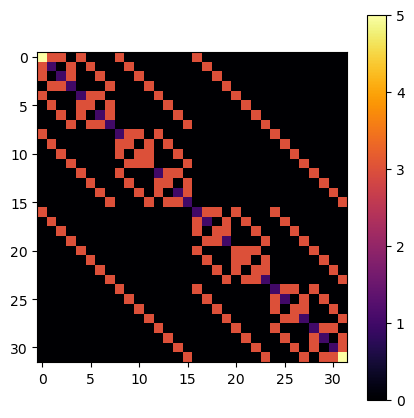

In [71]:
# set the qibo backend (we suggest qibojit if N >= 20)
# alternatives: tensorflow (not optimized), numpy (when CPU not supported by jit)
set_backend("qibojit", "numba")

# hamiltonian parameters
nqubits = 5
h = 3

# define the hamiltonian
h = hamiltonians.TFIM(nqubits=nqubits, h=h)

# initialize class
# Note: use deepcopy to prevent h being edited
dbi = DoubleBracketIteration(h,mode=DoubleBracketGeneratorType.single_commutator)
print("Initial off diagonal norm", dbi.off_diagonal_norm)
visualize_matrix(h.matrix)


## Local Z operators
Denoted as local Z operators, the diagonal operators used for this strategy are tensor products of pauli Z and identity.

In [72]:
generate_local_Z = generate_Z_operators(nqubits)
Z_ops = generate_local_Z["Z_operators"]
Z_names = generate_local_Z["Z_words"]

[Qibo 0.2.3|WARNING|2023-12-20 08:04:16]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.3|WARNING|2023-12-20 08:04:16]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.3|WARNING|2023-12-20 08:04:16]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.3|WARNING|2023-12-20 08:04:16]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.3|WARNING|2023-12-20 08:04:16]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.3|WARNING|2023-12-20 08:04:16]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.3|WARNING|2023-12-20 08:04:16]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.3|WARNING|2023-12-20 08:04:16]: Calculating the dens

## Iteration from list

In [73]:
NSTEPS = 10
Z_optimal = []
off_diagonal_norm_history = [dbi.off_diagonal_norm]
steps = [0]
for _ in range(NSTEPS):
    idx, step = iteration_from_list(dbi, Z_ops)
    off_diagonal_norm_history.append(dbi.off_diagonal_norm)
    steps.append(step)
    if idx == len(Z_ops):
        Z_optimal.append("canonical")
    else:
        Z_optimal.append(Z_names[idx])
    print(f"New optimized step at iteration {_}/{NSTEPS}: {step} with operator {Z_optimal[-1]}")

New optimized step at iteration 0/10: 0.29989505456927656 with operator ZZZZI
New optimized step at iteration 1/10: 0.035384129145876984 with operator ZIIIZ
New optimized step at iteration 2/10: 0.038786197728363433 with operator ZZZZI
New optimized step at iteration 3/10: 0.00011833388056278796 with operator canonical
New optimized step at iteration 4/10: 0.02004113466142011 with operator ZIIIZ
New optimized step at iteration 5/10: 0.09822226181866325 with operator IIZII
New optimized step at iteration 6/10: 0.02440788629523319 with operator ZZZZI
New optimized step at iteration 7/10: 0.09019567032207426 with operator ZZZII
New optimized step at iteration 8/10: 0.06994887800695226 with operator ZIZZI
New optimized step at iteration 9/10: 0.0004138275217389264 with operator canonical


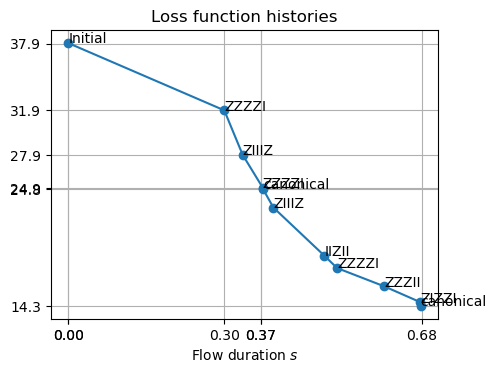

In [74]:
plot_histories(off_diagonal_norm_history, steps, Z_optimal)

## Compare with canonical

[Qibo 0.2.3|INFO|2023-12-20 08:04:36]: Using qibojit (numba) backend on /CPU:0


Initial off diagonal norm 37.94733192202055


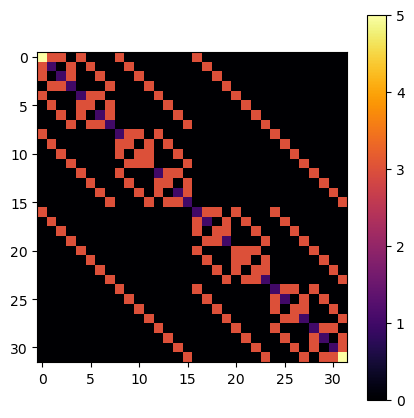

In [78]:
# set the qibo backend (we suggest qibojit if N >= 20)
# alternatives: tensorflow (not optimized), numpy (when CPU not supported by jit)
set_backend("qibojit", "numba")

# hamiltonian parameters
nqubits = 5
h = 3

# define the hamiltonian
h = hamiltonians.TFIM(nqubits=nqubits, h=h)

# initialize class|
# Note: use deepcopy to prevent h being edited
dbi_canonical = DoubleBracketIteration(h,mode=DoubleBracketGeneratorType.canonical)
print("Initial off diagonal norm", dbi_canonical.off_diagonal_norm)
visualize_matrix(h.matrix)

In [79]:
off_diagonal_norm_history = [dbi_canonical.off_diagonal_norm]
steps = [0]
for s in range(NSTEPS):
    if s != 0:
        step = dbi_canonical.hyperopt_step(
            step_min = 1e-5,
            step_max = 1,
            space = hp.uniform,
            optimizer = tpe,
            max_evals = 100,
        )
        print(f"New optimized step at iteration {s}/{NSTEPS}: {step}")
    dbi_canonical(step=step)
    off_diagonal_norm_history.append(dbi_canonical.off_diagonal_norm)
    steps.append(step)

New optimized step at iteration 1/10: 0.01793750114496096
New optimized step at iteration 2/10: 0.009205725351293752
New optimized step at iteration 3/10: 0.007968963636717416
New optimized step at iteration 4/10: 0.007300304878041382
New optimized step at iteration 5/10: 0.006149291001910284
New optimized step at iteration 6/10: 0.008468118348732902
New optimized step at iteration 7/10: 0.010900962182685027
New optimized step at iteration 8/10: 0.0096388986275741
New optimized step at iteration 9/10: 0.006651370934435026


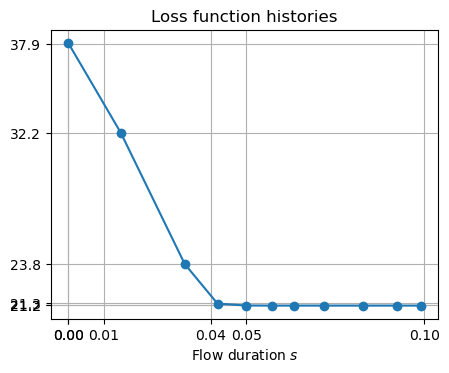

In [80]:
plot_histories(off_diagonal_norm_history, steps)

Here we see that variationally chosen diagonal operators are less likely to converge to a local minimum compared to the GWW flow